In [1]:
import os, sys, pickle, json, glob
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns

import torch
from collections import defaultdict

In [45]:
class ExtraFrame_Detector():
    def __init__(self, image_root, annotation_root):
        self.image_root = image_root
        self.annotation_root = annotation_root
    
    def get_annotation(self, name):
        with open(Path(self.annotation_root)/"again/{}/voc_multilabel.pkl".format(name), "rb") as f:
            annotation = pickle.load(f)
        return annotation
    
    
    def get_image_list(self, name):
        image_list = sorted(list((Path(self.image_root)/"again"/name).glob("0*.jpg")))
        return image_list

    
    def get_annotation_list(self, name):
        mask_list = sorted(list((Path(self.annotation_root)/"again"/name).glob("0*.png")))
        return mask_list
    
    
    def clop_image(self, image, annotation, frame_idx, object_idx, RGB=True):
        if RGB:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        x1, y1, x2, y2 = annotation[frame_idx]["box"][object_idx]
        image = image[int(y1):int(y2), int(x1):int(x2)]
        return image

    
    def get_TotalVariation_sobel(self, img, n=1, kernel_size=3, method=cv2.COLOR_BGR2GRAY):
        if method: # other method
            cvt_img = cv2.cvtColor(img, method)
        else: # gray
            assert img.ndim == 2
            cvt_img = img
        sobel_dx = cv2.Sobel(cvt_img, cv2.CV_8U, 1, 0, ksize=kernel_size)
        sobel_dy = cv2.Sobel(cvt_img, cv2.CV_8U, 0, 1, ksize=kernel_size)
        if n == 1:
            TV = (np.abs(sobel_dx) + np.abs(sobel_dy)).sum()
        elif n == 2:
            TV = np.power(np.power(sobel_dx, 2) + np.power(sobel_dy, 2), 0.5).sum()
        return TV, sobel_dx, sobel_dy

    
    def TV_flow(self, name, object_idx, n, kernel_size, d_thresh):
        annotation = self.get_annotation(name)
        image_list = self.get_image_list(name)
        annotation_list = self.get_annotation_list(name)
        TVs = list()
        for i in range(len(image_list)):
            img = self.clop_image(cv2.imread(str(image_list[i]), 0), annotation, frame_idx=i, object_idx=object_idx, RGB=False)
            if img.shape == (0,0):
                TVs.append(0)
                continue
            TV, _, _ = self.get_TotalVariation_sobel(img, n=1, kernel_size=kernel_size, method=None)
            TVs.append(TV)

        TVs = np.array(TVs)
        TVs = TVs / TVs.max()
        plt.plot(TVs, label="Total Variation")
        plt.ylabel("total variation (normalized)")
        plt.legend()

        d = list()
        d_idx = list()
        sobel_filter = np.array([-2, 0, 2])
        for i in range(len(TVs)-2):
            d_idx.append(i+1)
            d.append((sobel_filter * TVs[i:i+3]).sum())
        d = np.array(d)
        plt.plot(d_idx, d, label="diffarentiate")
        plt.legend()
        plt.grid()
        
        
        blur_frames = np.where(d > d_thresh)[0] 
#         blur_frames += 1
        
        return TVs, d, blur_frames
    

In [46]:
detector = ExtraFrame_Detector("/home/yhosoya/img_data/DAVIS/2017/DAVIS/JPEGImages",
                               "/home/yhosoya/img_data/DAVIS/2017/DAVIS/Annotations")

[37 38 44 50 60]


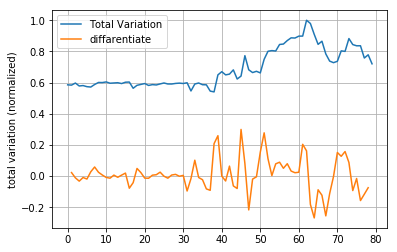

In [60]:
a, b, c = detector.TV_flow(name="bus", object_idx=0, n=1, kernel_size=3, d_thresh=0.2)
print(c)